## Why Multivariate Models?
- Stock Prices are often correlated, meaning one stock's moevement may influence another.
- Multivariate models allow us to leverage relationships between sotcks for better forecasting.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [32]:
# Load training data
X_train_apple = pd.read_csv("../data/tt_splits/X_train_apple.csv")
X_train_nvidia = pd.read_csv("../data/tt_splits/X_train_nvidia.csv")
X_train_microsoft = pd.read_csv("../data/tt_splits/X_train_microsoft.csv")

y_train_apple = pd.read_csv("../data/tt_splits/y_train_apple.csv")
y_train_nvidia = pd.read_csv("../data/tt_splits/y_train_nvidia.csv")
y_train_microsoft = pd.read_csv("../data/tt_splits/y_train_microsoft.csv")

# Load test data
X_test_apple = pd.read_csv("../data/tt_splits/X_test_apple.csv")
X_test_nvidia = pd.read_csv("../data/tt_splits/X_test_nvidia.csv")
X_test_microsoft = pd.read_csv("../data/tt_splits/X_test_microsoft.csv")

y_test_apple = pd.read_csv("../data/tt_splits/y_test_apple.csv")
y_test_nvidia = pd.read_csv("../data/tt_splits/y_test_nvidia.csv")
y_test_microsoft = pd.read_csv("../data/tt_splits/y_test_microsoft.csv")

In [33]:
# Ensure y values are properly formatted (flattening in case they are single-column dataframes)

y_train_apple = y_train_apple.values.ravel()
y_train_nvidia = y_train_nvidia.values.ravel()
y_train_microsoft = y_train_microsoft.values.ravel()

y_test_apple = y_test_apple.values.ravel()
y_test_nvidia = y_test_nvidia.values.ravel()
y_test_microsoft = y_test_microsoft.values.ravel()

We perform the following step, to be able to perform our cross stock analysis, we lose a portion of our data but we might be able to gain some insights from this.

In [34]:
# Find the minimum dataset lengths
min_train_length = min(len(y_train_apple), len(y_train_nvidia), len(y_train_microsoft))
min_test_length = min(len(y_test_apple), len(y_test_nvidia), len(y_test_microsoft))

# Trim training datasets to the smallest length
y_train_apple = y_train_apple[:min_train_length]
y_train_nvidia = y_train_nvidia[:min_train_length]
y_train_microsoft = y_train_microsoft[:min_train_length]

X_train_apple = X_train_apple[:min_train_length]
X_train_nvidia = X_train_nvidia[:min_train_length]
X_train_microsoft = X_train_microsoft[:min_train_length]

# Trim test datasets to the smallest length
y_test_apple = y_test_apple[:min_test_length]
y_test_nvidia = y_test_nvidia[:min_test_length]
y_test_microsoft = y_test_microsoft[:min_test_length]

X_test_apple = X_test_apple[:min_test_length]
X_test_nvidia = X_test_nvidia[:min_test_length]
X_test_microsoft = X_test_microsoft[:min_test_length]

In [35]:
# Combine datasets for cross-stock correlation analysis
X_train_multivariate = pd.concat([X_train_apple, X_train_nvidia, X_train_microsoft], axis=1, keys=["Apple", "NVIDIA", "Microsoft"])
X_test_multivariate = pd.concat([X_test_apple, X_test_nvidia, X_test_microsoft], axis=1, keys=["Apple", "NVIDIA", "Microsoft"])

y_train_multivariate = pd.DataFrame({"Apple": y_train_apple, "NVIDIA": y_train_nvidia, "Microsoft": y_train_microsoft})
y_test_multivariate = pd.DataFrame({"Apple": y_test_apple, "NVIDIA": y_test_nvidia, "Microsoft": y_test_microsoft})

In [36]:
# Verify the final dataset shapes
print(f"Final Training Shape: {X_train_multivariate.shape}, {y_train_multivariate.shape}")
print(f"Final Test Shape: {X_test_multivariate.shape}, {y_test_multivariate.shape}")

Final Training Shape: (5086, 33), (5086, 3)
Final Test Shape: (1272, 33), (1272, 3)


In [37]:
# Compute Pearson Correlation Matrix
correlation_matrix = y_train_multivariate.corr()

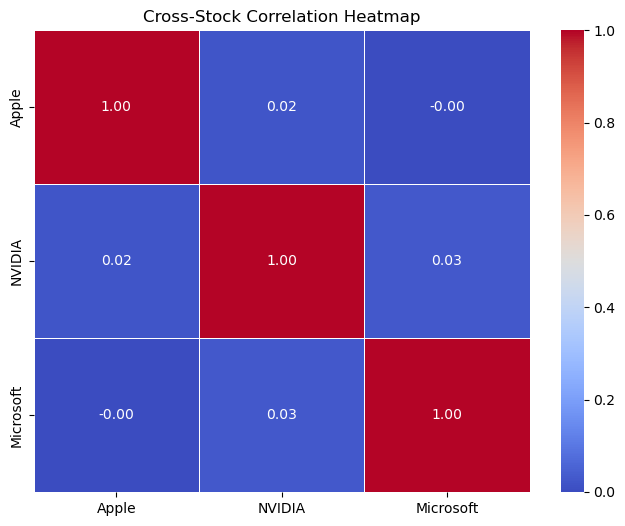

In [38]:
# Plot Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Cross-Stock Correlation Heatmap")
plt.show()

1. Low Correlations Between Stocks (0.00 to 0.03)
- Apple & NVIDIA: 0.02 (very weak correlation)
- Apple & Microsoft: -0.00 (essentially no correlation)
- NVIDIA & Microsoft: 0.03 (very weak correlation)

2. Why Are the Correlations So Low?
- A correlation of 1.00 means perfect similarity, while 0.00 means no relationship.
- The extremely low correlation values suggest that the daily stock price movements of Apple, NVIDIA, and Microsoft are largely independent.
- This might be due to different market influences, sector-specific volatility, or the fact that the dataset has been normalized in a way that removes strong dependencies.

3. Implications for Multivariate Modeling
- Little to no dependency between stocks means a multivariate model may not improve predictions significantly.
- Adding one stock's data to predict another's price may not be useful in this case.


Since we are already exploring a multivariate approach let's proceed with training a baseline multivariate model to verify wether combining stock features helps.

From our previous evaluations of single-stock models, the best-performing models (based on RMSE & R2 Score) were:
- XGBoost for Apple (Lowest RMSE for Apple)
- LightGBM for NVIDIA (Slightly better than XGBoost for NVIDIA)
- XGBoost for Microsoft (Almost identical to LightGBM, but slightly more stable)

Since XGBoost had the most consistent performance, we will use XGBoost for multivariate modeling.

In [39]:
# Initialize XGBoost Regressors for multivariate modeling
xgb_models = {
    "Apple": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "NVIDIA": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "Microsoft": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
}

# Train models using multivariate features
xgb_models["Apple"].fit(X_train_multivariate, y_train_multivariate["Apple"])
xgb_models["NVIDIA"].fit(X_train_multivariate, y_train_multivariate["NVIDIA"])
xgb_models["Microsoft"].fit(X_train_multivariate, y_train_multivariate["Microsoft"])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [40]:
# Predictions
predictions = {
    "Apple": xgb_models["Apple"].predict(X_test_multivariate),
    "NVIDIA": xgb_models["NVIDIA"].predict(X_test_multivariate),
    "Microsoft": xgb_models["Microsoft"].predict(X_test_multivariate),
}

In [41]:
# Evaluation Metrics
metrics = {
    stock: {
        "MSE": mean_squared_error(y_test_multivariate[stock], preds),
        "RMSE": np.sqrt(mean_squared_error(y_test_multivariate[stock], preds)),
        "MAE": mean_absolute_error(y_test_multivariate[stock], preds),
        "R² Score": r2_score(y_test_multivariate[stock], preds),
    }
    for stock, preds in predictions.items()
}

In [42]:
# Convert Metrics Dictionary to Dataframe

metrics_df = pd.DataFrame(metrics).T
metrics_df

,MSE,RMSE,MAE,R² Score
Apple,0.015044,0.122654,0.115986,-9.108774
NVIDIA,0.022442,0.149806,0.133871,-3.355534
Microsoft,0.002784,0.052761,0.044935,-1.455494


**MSE:**
- Apple and NVIDIA show significantly higher error than Microsoft, suggesting that cross-stock relationships are not improving predictions.

**MAE:**
- Again, Microsoft is the easiest stock to predict, while Apple and NVIDIA perform poorly in a multivariate setting.

**R Square Score:**
- Apple's R² score of -9.11 is the worst we've seen so far!
- This means the multivariate model for Apple is performing drastically worse than a naive mean-based predictor.
- NVIDIA's R² (-3.36) is also quite poor, suggesting that using cross-stock features does not improve accuracy.
- Microsoft’s R² (-1.46) is slightly better, but still negative.


**Key Takeaways:**

1. Multivariate modeling did not improve stock predictions.
- Apple’s performance deteriorated the most, meaning NVIDIA and Microsoft’s stock features do not help in predicting Apple’s stock.
- NVIDIA also performs worse than its individual model.
- Microsoft is slightly better but still underperforms compared to univariate models.

2. Stock movements appear largely independent.
- As we saw in the correlation heatmap, Apple, NVIDIA, and Microsoft have weak correlations (~0.02 to 0.03).
- This suggests that these stocks do not significantly impact each other’s movements.
- Sector-based stocks (e.g., multiple semiconductor stocks) might be better candidates for multivariate models.

3. Multivariate models are not suitable for this dataset.
- The sharp decline in performance confirms that cross-stock data does not provide useful additional signals.
- A better approach would be to focus on macroeconomic indicators (e.g., interest rates, market indices, sector ETFs).

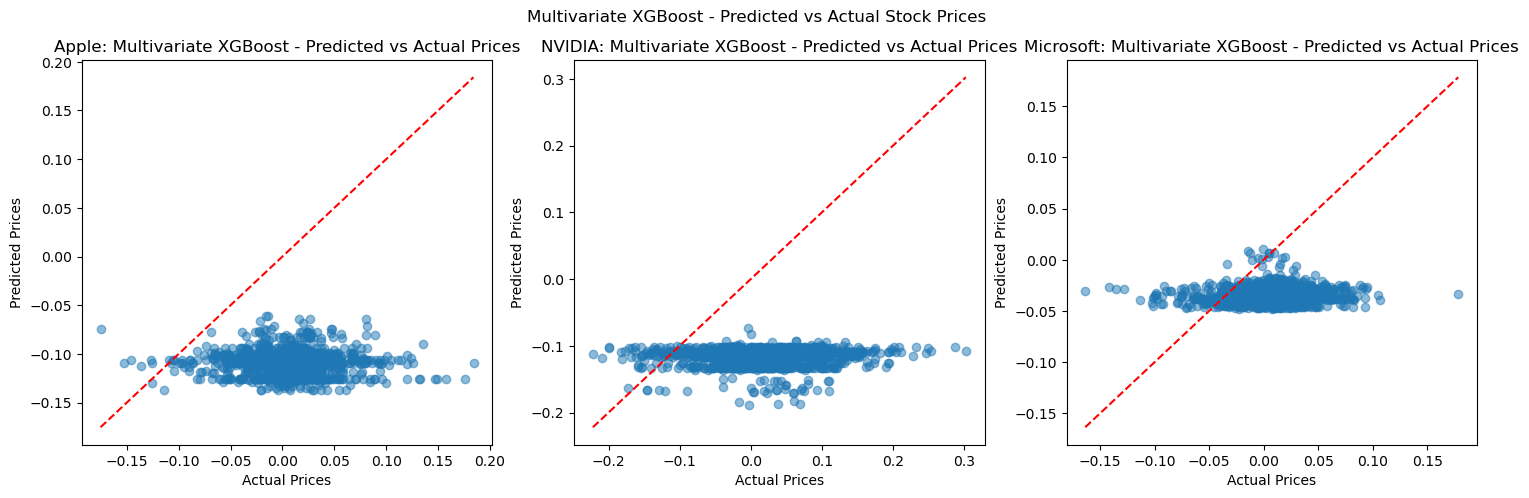

In [43]:
# Plot Predicted vs Actual Prices for each stock using the Multivariate XGBoost Model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

stocks = ["Apple", "NVIDIA", "Microsoft"]
predictions = [predictions["Apple"], predictions["NVIDIA"], predictions["Microsoft"]]
actuals = [y_test_multivariate["Apple"], y_test_multivariate["NVIDIA"], y_test_multivariate["Microsoft"]]

for i, (stock, preds, y_test) in enumerate(zip(stocks, predictions, actuals)):
    axes[i].scatter(y_test, preds, alpha=0.5)
    axes[i].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed')  # Perfect Fit Line
    axes[i].set_xlabel("Actual Prices")
    axes[i].set_ylabel("Predicted Prices")
    axes[i].set_title(f"{stock}: Multivariate XGBoost - Predicted vs Actual Prices")

plt.suptitle("Multivariate XGBoost - Predicted vs Actual Stock Prices")
plt.show()

**Apple Stock:** 
- Predictions are largely clustered around -0.10 regardless of the actual price.
- No clear alignment with the red dashed line (ideal predictions).
- This confirms extremely poor performance (-9.11 R² score) where the model struggles to capture stock movements.

**NVIDIA Stock:**
- Most predictions hover around -0.10, failing to capture price changes.
- High variance and extreme outliers, suggesting the model is overfitting to certain levels.
- The model fails to generalize price movements accurately.

**Microsoft Stock:**
- Slightly better clustering along the red dashed line, but still far from an ideal prediction.
- The model tends to predict values close to the mean rather than capturing actual price trends.

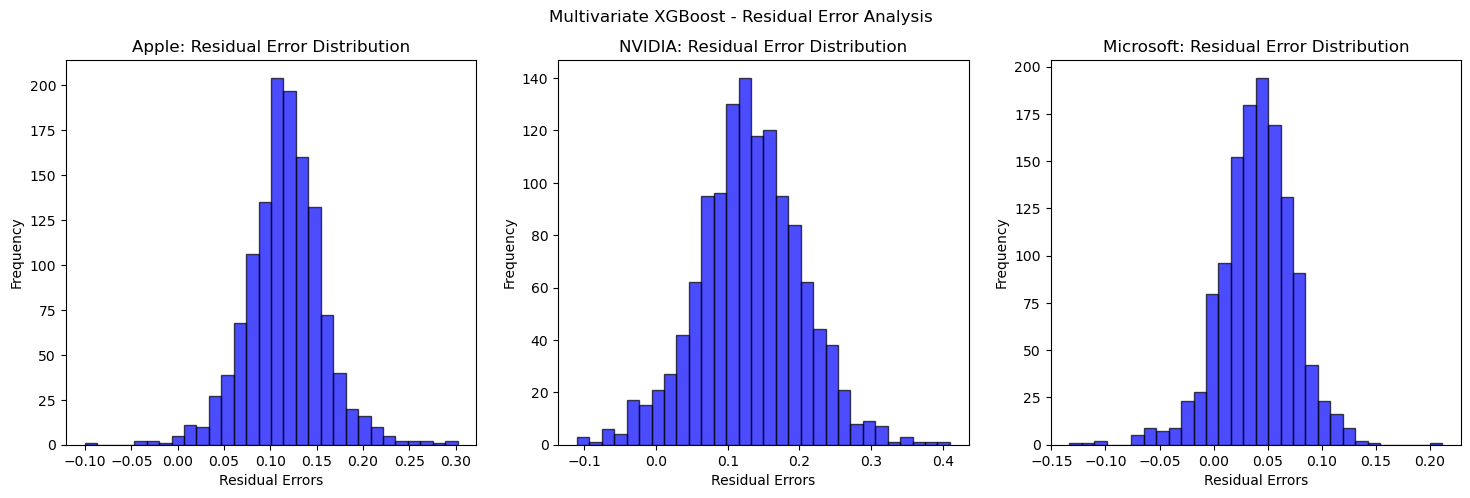

In [44]:
# Plot Residual Errors
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (stock, preds, y_test) in enumerate(zip(stocks, predictions, actuals)):
    residuals = y_test - preds
    axes[i].hist(residuals, bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[i].set_xlabel("Residual Errors")
    axes[i].set_ylabel("Frequency")
    axes[i].set_title(f"{stock}: Residual Error Distribution")

plt.suptitle("Multivariate XGBoost - Residual Error Analysis")
plt.show()

**Apple Stock:** 
- Residuals are centered around 0.10 to 0.15, meaning the model consistently overestimates prices.
- A right-skewed error distribution suggests that predictions tend to be higher than actual values.

**NVIDIA Stock:**
- A similar pattern, with most residuals between 0.10 and 0.20.
- Again, the model overestimates NVIDIA stock prices, failing to capture downward movements properly.

**Microsoft Stock:**
- The error distribution is narrower compared to Apple and NVIDIA.
- Microsoft shows less overestimation, but errors still cluster around 0.05 to 0.10.